In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import torch.nn.functional as F
import numpy as np
import pandas as pd 
from math import ceil
from numpy import load

In [2]:
def load_emb_data(file_name):
    # load dict of arrays
    dict_data = load(f"../../data/processed/{file_name}.npz")
    # extract the first array
    return dict_data['arr_0']

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
feature_vec = load_emb_data("combine_feature")
title_vec = load_emb_data("combine_title")
index = load_emb_data("combine_index")
label = load_emb_data("combine_label")

In [4]:
class ParallelLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, lstm_hidden_size, num_classes, num_lstm_layers=3, dropout_prob=0.3):
        super(ParallelLSTMClassifier, self).__init__()
        
        # Define the layers for the first path
        self.path1_fc1 = nn.Linear(input_size, hidden_size)
        self.path1_dropout1 = nn.Dropout(dropout_prob)
        self.path1_fc2 = nn.Linear(hidden_size, int(hidden_size / 2))
        self.path1_dropout2 = nn.Dropout(dropout_prob)
        
        # Define the layers for the second path
        self.path2_fc1 = nn.Linear(input_size, hidden_size)
        self.path2_dropout1 = nn.Dropout(dropout_prob)
        self.path2_fc2 = nn.Linear(hidden_size, int(hidden_size / 2))
        self.path2_dropout2 = nn.Dropout(dropout_prob)
        
        self.lstm = nn.LSTM(hidden_size, lstm_hidden_size, drop_out=0.3, batch_first=True)
        
        # Define the final dense layer
        self.final_fc = nn.Linear(lstm_hidden_size, num_classes)
        
    def forward(self, x):
        # Split the input into two subarrays
        x1, x2 = x[:, 0, :], x[:, 1, :]
        
        # First path
        x1 = self.path1_fc1(x1)
        x1 = self.path1_dropout1(x1)
        x1 = torch.relu(x1)
        x1 = self.path1_fc2(x1)
        x1 = self.path1_dropout2(x1)
        x1 = torch.relu(x1)
        
        # Second path
        x2 = self.path2_fc1(x2)
        x2 = self.path2_dropout1(x2)
        x2 = torch.relu(x2)
        x2 = self.path2_fc2(x2)
        x2 = self.path2_dropout2(x2)
        x2 = torch.relu(x2)
        
        # Combine the outputs of the two paths
        combined = torch.cat((x1, x2), dim=1)
        combined = combined.unsqueeze(1)  # Add sequence length dimension

        lstm_out, _ = self.lstm(combined)
        lstm_out = lstm_out[:, -1, :]  # Get the output of the last LSTM cell
        
        # Final dense layer
        out = self.final_fc(lstm_out)

        # # Combine the outputs of the two paths
        # x = torch.cat((x1, x2), dim=1)
        # x = x.unsqueeze(1)  # Add sequence length dimension
        
        # # LSTM layer
        # for lstm, dropout in zip(self.lstm_layers, self.dropout_layers):
        #     x, _ = lstm(x)
        #     x = dropout(x)
        # x = x[:, -1, :]  # Get the output of the last LSTM cell
        # # out = self.final_fc(x)

        return out

In [5]:
# Create dataset
batch_size = 32
inputs = torch.tensor(np.stack((title_vec, feature_vec), axis=1), dtype=torch.float32)
targets = torch.tensor(label, dtype=torch.long)

dataset = TensorDataset(inputs, targets)

# Split dataset into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# Hyperparameters
input_size = 768
hidden_size = 128
lstm_hidden_size = 64
num_classes = 3
dropout_prob = 0.3

# Initialize the model
model = ParallelLSTMClassifier(input_size, hidden_size, lstm_hidden_size, 
                               num_classes, dropout_prob).to(device)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epoch_loss = []
# Training loop
num_epochs = 40
# Training loop
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation loop
model.eval()
all_targets = []
all_predictions = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate accuracy and F1 score
accuracy = accuracy_score(all_targets, all_predictions)
f1 = f1_score(all_targets, all_predictions, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

Epoch [1/40], Loss: 0.3122
Epoch [2/40], Loss: 0.5303
Epoch [3/40], Loss: 0.2651
Epoch [4/40], Loss: 0.4819
Epoch [5/40], Loss: 0.0545
Epoch [6/40], Loss: 0.2629
Epoch [7/40], Loss: 0.2490
Epoch [8/40], Loss: 0.7287
Epoch [9/40], Loss: 0.1623
Epoch [10/40], Loss: 0.2407
Epoch [11/40], Loss: 0.3886
Epoch [12/40], Loss: 0.2909
Epoch [13/40], Loss: 0.3088
Epoch [14/40], Loss: 0.2698
Epoch [15/40], Loss: 0.3739
Epoch [16/40], Loss: 0.1287
Epoch [17/40], Loss: 0.0413
Epoch [18/40], Loss: 0.1776
Epoch [19/40], Loss: 0.3010
Epoch [20/40], Loss: 0.2647
Epoch [21/40], Loss: 0.2124
Epoch [22/40], Loss: 0.1142
Epoch [23/40], Loss: 0.2137
Epoch [24/40], Loss: 0.2116
Epoch [25/40], Loss: 0.1761
Epoch [26/40], Loss: 0.2837
Epoch [27/40], Loss: 0.1137
Epoch [28/40], Loss: 0.1663
Epoch [29/40], Loss: 0.4093
Epoch [30/40], Loss: 0.0763
Epoch [31/40], Loss: 0.0584
Epoch [32/40], Loss: 0.2359
Epoch [33/40], Loss: 0.0412
Epoch [34/40], Loss: 0.0644
Epoch [35/40], Loss: 0.0731
Epoch [36/40], Loss: 0.2937
E

In [8]:
model, sum(p.numel() for p in model.parameters())

(ParallelLSTMClassifier(
   (path1_fc1): Linear(in_features=768, out_features=128, bias=True)
   (path1_dropout1): Dropout(p=0.3, inplace=False)
   (path1_fc2): Linear(in_features=128, out_features=64, bias=True)
   (path1_dropout2): Dropout(p=0.3, inplace=False)
   (path2_fc1): Linear(in_features=768, out_features=128, bias=True)
   (path2_dropout1): Dropout(p=0.3, inplace=False)
   (path2_fc2): Linear(in_features=128, out_features=64, bias=True)
   (path2_dropout2): Dropout(p=0.3, inplace=False)
   (lstm): LSTM(128, 64, batch_first=True)
   (final_fc): Linear(in_features=64, out_features=3, bias=True)
 ),
 263235)

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print(classification_report(all_targets, all_predictions))

confusion_matrix(all_targets, all_predictions)

              precision    recall  f1-score   support

           0       0.82      0.87      0.85      2478
           1       0.95      0.96      0.96      2504
           2       0.86      0.80      0.83      2518

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500



array([[2163,   35,  280],
       [  41, 2406,   57],
       [ 419,   81, 2018]], dtype=int64)

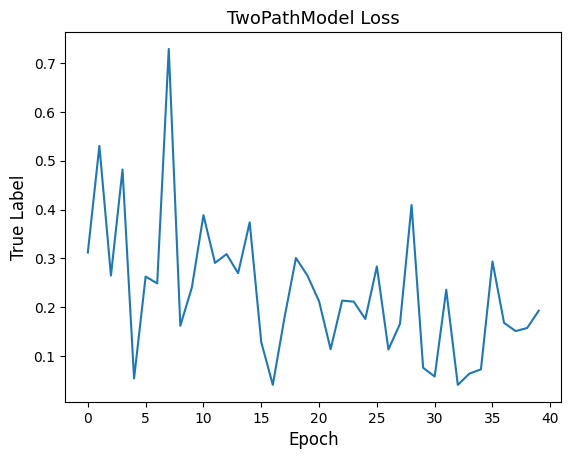

In [10]:
from matplotlib import pyplot as plt 
import seaborn as sns 
plt.plot(range(num_epochs), epoch_loss)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title('TwoPathModel Loss', fontsize=13)
plt.savefig("images/twopathloss", bbox_inches="tight")

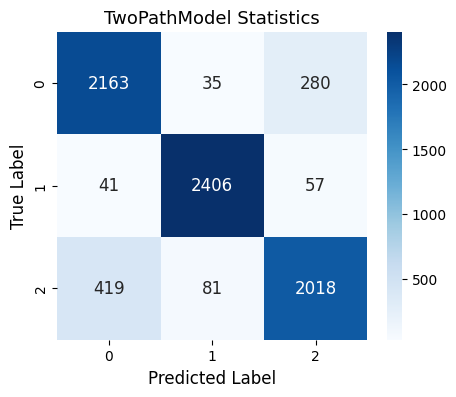

In [13]:
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(all_targets, all_predictions), annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title('TwoPathModel Statistics', fontsize=13)
plt.savefig("images/twopath", bbox_inches="tight")

In [12]:
# model_path = "../../src/weights/nn_twopath.pth"

# # Save the model's state dictionary
# torch.save(model.state_dict(), model_path)

# Load trained model

In [ ]:
# Load the model state dictionary
model = ClassificationModel(input_size, hidden_size, num_classes)
model.load_state_dict(torch.load("../../src/models/nn_bert_title.pth"))
model.to(device)

ClassificationModel(
  (dense1): Linear(in_features=768, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(128, 128, batch_first=True)
  (dense2): Linear(in_features=128, out_features=3, bias=True)
)

In [ ]:
inputs = title_bert_vec
targets = title_label

# Convert to PyTorch tensors
inputs = torch.tensor(inputs, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.long)

# Create dataset
dataset = TensorDataset(inputs, targets)

# Create data loaders
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Evaluation loop
model.eval()
all_targets = []
all_predictions = []

with torch.no_grad():
    for batch_inputs, batch_targets in data_loader:
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
        outputs = model(batch_inputs)
        _, predicted = torch.max(outputs, 1)
        all_targets.extend(batch_targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate accuracy and F1 score
accuracy = accuracy_score(all_targets, all_predictions)
f1 = f1_score(all_targets, all_predictions, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9809
F1 Score: 0.9809
